In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [10]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


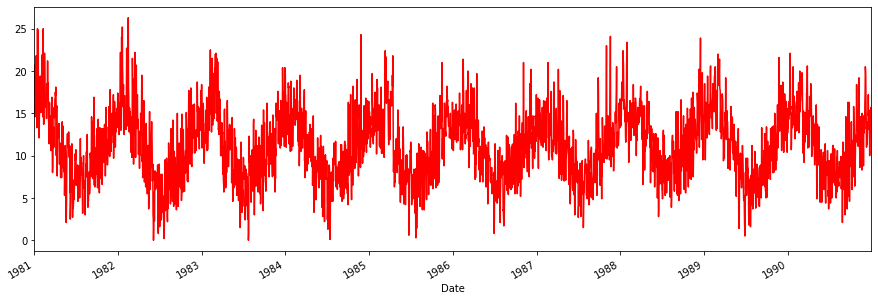

In [4]:
 df.Temp.plot(figsize=(15,5), color="r")

# Dataset Splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [8]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [9]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)


(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [23]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [24]:
config = set_config({
    "input_size" : train_set.n_feature,
    "seq_len" : train_set.n_seq,
    "output_size" : 1, 
    "hidden_size" : 64, 
    "num_layers"  : 2,
    "dropout"     : 0
})

# Training Preparation -> MCOC

In [28]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/rnn")

# Training

In [29]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 118.3911 | Test_cost  = 103.8209 | 




Epoch     2
Train_cost  = 86.5310 | Test_cost  = 78.7318 | 




Epoch     3
Train_cost  = 66.6098 | Test_cost  = 63.8702 | 




Epoch     4
Train_cost  = 54.9733 | Test_cost  = 54.8996 | 




Epoch     5
Train_cost  = 47.6214 | Test_cost  = 48.4825 | 




Epoch     6
Train_cost  = 42.1119 | Test_cost  = 43.2853 | 




Epoch     7
Train_cost  = 37.5839 | Test_cost  = 38.8863 | 




Epoch     8
Train_cost  = 33.7631 | Test_cost  = 35.1370 | 




Epoch     9
Train_cost  = 30.5347 | Test_cost  = 31.9501 | 




Epoch    10
Train_cost  = 27.8203 | Test_cost  = 29.2550 | 




Epoch    11
Train_cost  = 25.5530 | Test_cost  = 26.9891 | 




Epoch    12
Train_cost  = 23.6733 | Test_cost  = 25.0958 | 




Epoch    13
Train_cost  = 22.1273 | Test_cost  = 23.5238 | 




Epoch    14
Train_cost  = 20.8662 | Test_cost  = 22.2271 | 




Epoch    15
Train_cost  = 19.8465 | Test_cost  = 21.1643 | 




Epoch    16
Train_cost  = 19.0292 | Test_cost  = 20.2985 | 




Epoch    17
Train_cost  = 18.3800 | Test_cost  = 19.5975 | 




Epoch    18
Train_cost  = 17.8691 | Test_cost  = 19.0330 | 




Epoch    19
Train_cost  = 17.4706 | Test_cost  = 18.5807 | 




Epoch    20
Train_cost  = 17.1625 | Test_cost  = 18.2198 | 


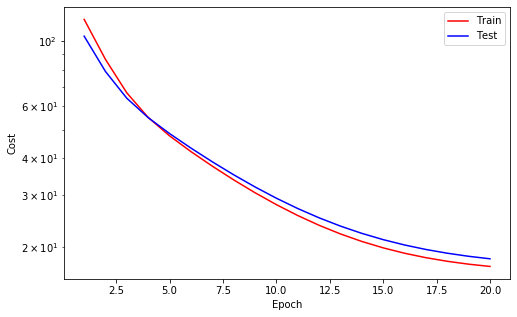



Epoch    21
Train_cost  = 16.9263 | Test_cost  = 17.9330 | 




Epoch    22
Train_cost  = 16.7467 | Test_cost  = 17.7055 | 




Epoch    23
Train_cost  = 16.6109 | Test_cost  = 17.5254 | 




Epoch    24
Train_cost  = 16.5089 | Test_cost  = 17.3828 | 




Epoch    25
Train_cost  = 16.4324 | Test_cost  = 17.2698 | 




Epoch    26
Train_cost  = 16.3751 | Test_cost  = 17.1799 | 




Epoch    27
Train_cost  = 16.3318 | Test_cost  = 17.1079 | 




Epoch    28
Train_cost  = 16.2986 | Test_cost  = 17.0498 | 




Epoch    29
Train_cost  = 16.2724 | Test_cost  = 17.0022 | 




Epoch    30
Train_cost  = 16.2507 | Test_cost  = 16.9621 | 




Epoch    31
Train_cost  = 16.2315 | Test_cost  = 16.9274 | 




Epoch    32
Train_cost  = 16.2130 | Test_cost  = 16.8959 | 




Epoch    33
Train_cost  = 16.1936 | Test_cost  = 16.8654 | 




Epoch    34
Train_cost  = 16.1710 | Test_cost  = 16.8324 | 




Epoch    35
Train_cost  = 16.1409 | Test_cost  = 16.7906 | 




Epoch    36
Train_cost  = 16.0948 | Test_cost  = 16.7270 | 




Epoch    37
Train_cost  = 16.0113 | Test_cost  = 16.5991 | 




Epoch    38
Train_cost  = 15.8094 | Test_cost  = 16.2350 | 




Epoch    39
Train_cost  = 15.1779 | Test_cost  = 15.3042 | 




Epoch    40
Train_cost  = 14.2675 | Test_cost  = 14.6770 | 


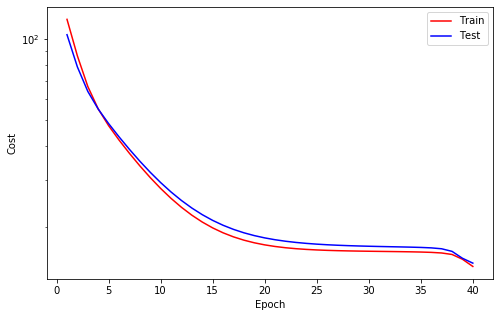



Epoch    41
Train_cost  = 13.4215 | Test_cost  = 13.9082 | 




Epoch    42
Train_cost  = 12.8784 | Test_cost  = 13.2567 | 




Epoch    43
Train_cost  = 12.2498 | Test_cost  = 12.4700 | 




Epoch    44
Train_cost  = 11.6725 | Test_cost  = 11.7526 | 




Epoch    45
Train_cost  = 11.1280 | Test_cost  = 11.1249 | 




Epoch    46
Train_cost  = 10.6494 | Test_cost  = 10.6382 | 




Epoch    47
Train_cost  = 10.3036 | Test_cost  = 10.1858 | 




Epoch    48
Train_cost  = 9.9839 | Test_cost  = 9.7841 | 




Epoch    49
Train_cost  = 9.6689 | Test_cost  = 9.4353 | 




Epoch    50
Train_cost  = 9.4063 | Test_cost  = 9.1260 | 




Epoch    51
Train_cost  = 9.1887 | Test_cost  = 8.8416 | 




Epoch    52
Train_cost  = 8.9850 | Test_cost  = 8.5876 | 




Epoch    53
Train_cost  = 8.7919 | Test_cost  = 8.3650 | 




Epoch    54
Train_cost  = 8.6246 | Test_cost  = 8.1699 | 




Epoch    55
Train_cost  = 8.4832 | Test_cost  = 7.9933 | 




Epoch    56
Train_cost  = 8.3545 | Test_cost  = 7.8282 | 




Epoch    57
Train_cost  = 8.2298 | Test_cost  = 7.6772 | 




Epoch    58
Train_cost  = 8.1104 | Test_cost  = 7.5418 | 




Epoch    59
Train_cost  = 8.0007 | Test_cost  = 7.4188 | 




Epoch    60
Train_cost  = 7.9022 | Test_cost  = 7.3057 | 


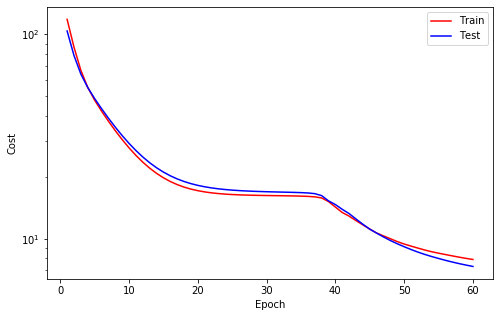



Epoch    61
Train_cost  = 7.8130 | Test_cost  = 7.2007 | 




Epoch    62
Train_cost  = 7.7303 | Test_cost  = 7.1025 | 




Epoch    63
Train_cost  = 7.6528 | Test_cost  = 7.0113 | 




Epoch    64
Train_cost  = 7.5804 | Test_cost  = 6.9269 | 




Epoch    65
Train_cost  = 7.5135 | Test_cost  = 6.8483 | 




Epoch    66
Train_cost  = 7.4516 | Test_cost  = 6.7751 | 




Epoch    67
Train_cost  = 7.3942 | Test_cost  = 6.7064 | 




Epoch    68
Train_cost  = 7.3406 | Test_cost  = 6.6417 | 




Epoch    69
Train_cost  = 7.2903 | Test_cost  = 6.5808 | 




Epoch    70
Train_cost  = 7.2429 | Test_cost  = 6.5234 | 




Epoch    71
Train_cost  = 7.1982 | Test_cost  = 6.4692 | 




Epoch    72
Train_cost  = 7.1560 | Test_cost  = 6.4180 | 




Epoch    73
Train_cost  = 7.1162 | Test_cost  = 6.3697 | 




Epoch    74
Train_cost  = 7.0785 | Test_cost  = 6.3240 | 




Epoch    75
Train_cost  = 7.0429 | Test_cost  = 6.2808 | 




Epoch    76
Train_cost  = 7.0091 | Test_cost  = 6.2400 | 




Epoch    77
Train_cost  = 6.9770 | Test_cost  = 6.2013 | 




Epoch    78
Train_cost  = 6.9466 | Test_cost  = 6.1647 | 




Epoch    79
Train_cost  = 6.9178 | Test_cost  = 6.1300 | 




Epoch    80
Train_cost  = 6.8905 | Test_cost  = 6.0971 | 


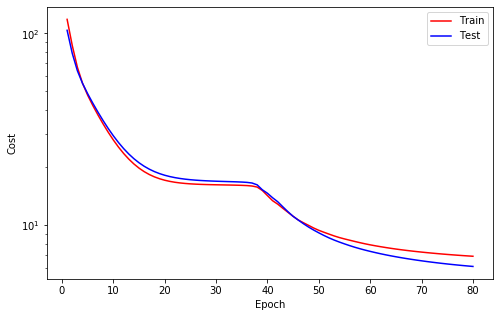



Epoch    81
Train_cost  = 6.8645 | Test_cost  = 6.0659 | 




Epoch    82
Train_cost  = 6.8398 | Test_cost  = 6.0364 | 




Epoch    83
Train_cost  = 6.8162 | Test_cost  = 6.0083 | 




Epoch    84
Train_cost  = 6.7939 | Test_cost  = 5.9816 | 




Epoch    85
Train_cost  = 6.7725 | Test_cost  = 5.9563 | 




Epoch    86
Train_cost  = 6.7522 | Test_cost  = 5.9321 | 




Epoch    87
Train_cost  = 6.7327 | Test_cost  = 5.9091 | 




Epoch    88
Train_cost  = 6.7141 | Test_cost  = 5.8872 | 




Epoch    89
Train_cost  = 6.6964 | Test_cost  = 5.8663 | 




Epoch    90
Train_cost  = 6.6793 | Test_cost  = 5.8463 | 




Epoch    91
Train_cost  = 6.6630 | Test_cost  = 5.8271 | 




Epoch    92
Train_cost  = 6.6474 | Test_cost  = 5.8088 | 




Epoch    93
Train_cost  = 6.6323 | Test_cost  = 5.7913 | 




Epoch    94
Train_cost  = 6.6179 | Test_cost  = 5.7744 | 




Epoch    95
Train_cost  = 6.6040 | Test_cost  = 5.7583 | 




Epoch    96
Train_cost  = 6.5906 | Test_cost  = 5.7427 | 




Epoch    97
Train_cost  = 6.5777 | Test_cost  = 5.7277 | 




Epoch    98
Train_cost  = 6.5652 | Test_cost  = 5.7133 | 




Epoch    99
Train_cost  = 6.5532 | Test_cost  = 5.6994 | 




Epoch   100
Train_cost  = 6.5415 | Test_cost  = 5.6860 | 


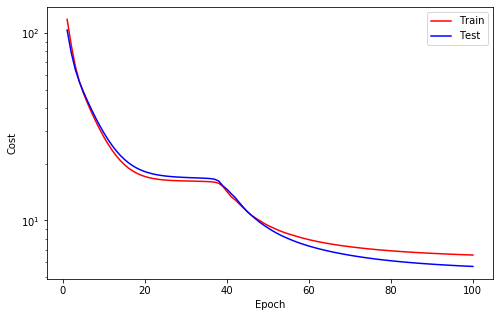



Epoch   101
Train_cost  = 6.5303 | Test_cost  = 5.6731 | 




Epoch   102
Train_cost  = 6.5194 | Test_cost  = 5.6605 | 




Epoch   103
Train_cost  = 6.5088 | Test_cost  = 5.6484 | 




Epoch   104
Train_cost  = 6.4985 | Test_cost  = 5.6367 | 




Epoch   105
Train_cost  = 6.4886 | Test_cost  = 5.6253 | 




Epoch   106
Train_cost  = 6.4789 | Test_cost  = 5.6143 | 




Epoch   107
Train_cost  = 6.4695 | Test_cost  = 5.6036 | 




Epoch   108
Train_cost  = 6.4603 | Test_cost  = 5.5932 | 




Epoch   109
Train_cost  = 6.4514 | Test_cost  = 5.5831 | 




Epoch   110
Train_cost  = 6.4427 | Test_cost  = 5.5733 | 




Epoch   111
Train_cost  = 6.4342 | Test_cost  = 5.5637 | 




Epoch   112
Train_cost  = 6.4259 | Test_cost  = 5.5545 | 




Epoch   113
Train_cost  = 6.4178 | Test_cost  = 5.5454 | 




Epoch   114
Train_cost  = 6.4099 | Test_cost  = 5.5366 | 




Epoch   115
Train_cost  = 6.4021 | Test_cost  = 5.5280 | 




Epoch   116
Train_cost  = 6.3945 | Test_cost  = 5.5197 | 




Epoch   117
Train_cost  = 6.3871 | Test_cost  = 5.5115 | 




Epoch   118
Train_cost  = 6.3799 | Test_cost  = 5.5035 | 




Epoch   119
Train_cost  = 6.3728 | Test_cost  = 5.4958 | 




Epoch   120
Train_cost  = 6.3658 | Test_cost  = 5.4882 | 


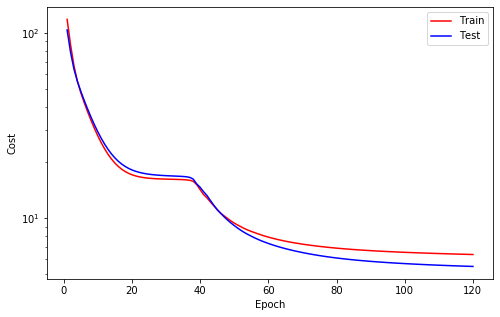



Epoch   121
Train_cost  = 6.3589 | Test_cost  = 5.4807 | 




Epoch   122
Train_cost  = 6.3522 | Test_cost  = 5.4735 | 




Epoch   123
Train_cost  = 6.3456 | Test_cost  = 5.4664 | 




Epoch   124
Train_cost  = 6.3392 | Test_cost  = 5.4594 | 




Epoch   125
Train_cost  = 6.3328 | Test_cost  = 5.4526 | 




Epoch   126
Train_cost  = 6.3266 | Test_cost  = 5.4459 | 




Epoch   127
Train_cost  = 6.3204 | Test_cost  = 5.4393 | 




Epoch   128
Train_cost  = 6.3144 | Test_cost  = 5.4329 | 




Epoch   129
Train_cost  = 6.3085 | Test_cost  = 5.4266 | 




Epoch   130
Train_cost  = 6.3027 | Test_cost  = 5.4204 | 




Epoch   131
Train_cost  = 6.2969 | Test_cost  = 5.4144 | 




Epoch   132
Train_cost  = 6.2913 | Test_cost  = 5.4084 | 




Epoch   133
Train_cost  = 6.2858 | Test_cost  = 5.4026 | 




Epoch   134
Train_cost  = 6.2803 | Test_cost  = 5.3968 | 




Epoch   135
Train_cost  = 6.2749 | Test_cost  = 5.3912 | 




Epoch   136
Train_cost  = 6.2696 | Test_cost  = 5.3856 | 




Epoch   137
Train_cost  = 6.2644 | Test_cost  = 5.3802 | 




Epoch   138
Train_cost  = 6.2593 | Test_cost  = 5.3748 | 




Epoch   139
Train_cost  = 6.2543 | Test_cost  = 5.3695 | 




Epoch   140
Train_cost  = 6.2493 | Test_cost  = 5.3644 | 


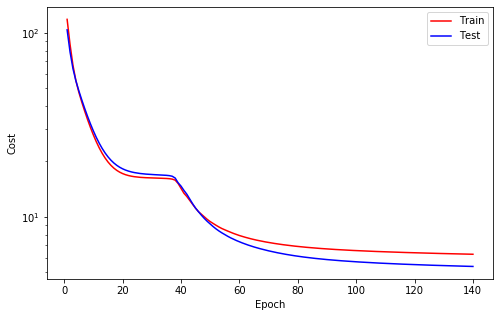



Epoch   141
Train_cost  = 6.2444 | Test_cost  = 5.3593 | 




Epoch   142
Train_cost  = 6.2396 | Test_cost  = 5.3543 | 




Epoch   143
Train_cost  = 6.2349 | Test_cost  = 5.3493 | 




Epoch   144
Train_cost  = 6.2302 | Test_cost  = 5.3445 | 




Epoch   145
Train_cost  = 6.2256 | Test_cost  = 5.3398 | 




Epoch   146
Train_cost  = 6.2211 | Test_cost  = 5.3351 | 




Epoch   147
Train_cost  = 6.2166 | Test_cost  = 5.3306 | 




Epoch   148
Train_cost  = 6.2122 | Test_cost  = 5.3261 | 




Epoch   149
Train_cost  = 6.2079 | Test_cost  = 5.3218 | 




Epoch   150
Train_cost  = 6.2036 | Test_cost  = 5.3175 | 




Epoch   151
Train_cost  = 6.1994 | Test_cost  = 5.3134 | 




Epoch   152
Train_cost  = 6.1952 | Test_cost  = 5.3093 | 




Epoch   153
Train_cost  = 6.1911 | Test_cost  = 5.3053 | 




Epoch   154
Train_cost  = 6.1871 | Test_cost  = 5.3015 | 




Epoch   155
Train_cost  = 6.1832 | Test_cost  = 5.2977 | 




Epoch   156
Train_cost  = 6.1792 | Test_cost  = 5.2940 | 




Epoch   157
Train_cost  = 6.1754 | Test_cost  = 5.2905 | 




Epoch   158
Train_cost  = 6.1716 | Test_cost  = 5.2870 | 




Epoch   159
Train_cost  = 6.1678 | Test_cost  = 5.2836 | 




Epoch   160
Train_cost  = 6.1641 | Test_cost  = 5.2804 | 


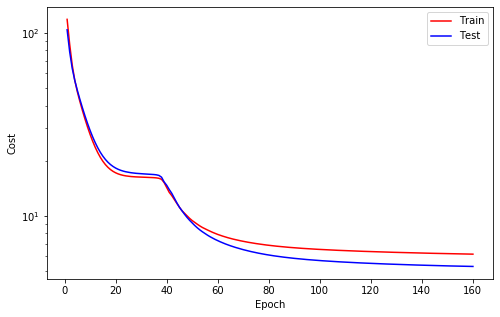



Epoch   161
Train_cost  = 6.1604 | Test_cost  = 5.2772 | 




Epoch   162
Train_cost  = 6.1568 | Test_cost  = 5.2742 | 




Epoch   163
Train_cost  = 6.1532 | Test_cost  = 5.2712 | 




Epoch   164
Train_cost  = 6.1496 | Test_cost  = 5.2684 | 




Epoch   165
Train_cost  = 6.1461 | Test_cost  = 5.2656 | 




Epoch   166
Train_cost  = 6.1426 | Test_cost  = 5.2630 | 




Epoch   167
Train_cost  = 6.1391 | Test_cost  = 5.2604 | 




Epoch   168
Train_cost  = 6.1356 | Test_cost  = 5.2580 | 




Epoch   169
Train_cost  = 6.1322 | Test_cost  = 5.2556 | 




Epoch   170
Train_cost  = 6.1287 | Test_cost  = 5.2534 | 




Epoch   171
Train_cost  = 6.1253 | Test_cost  = 5.2512 | 




Epoch   172
Train_cost  = 6.1219 | Test_cost  = 5.2492 | 




Epoch   173
Train_cost  = 6.1185 | Test_cost  = 5.2472 | 




Epoch   174
Train_cost  = 6.1150 | Test_cost  = 5.2454 | 




Epoch   175
Train_cost  = 6.1116 | Test_cost  = 5.2436 | 




Epoch   176
Train_cost  = 6.1082 | Test_cost  = 5.2420 | 




Epoch   177
Train_cost  = 6.1048 | Test_cost  = 5.2404 | 




Epoch   178
Train_cost  = 6.1014 | Test_cost  = 5.2389 | 




Epoch   179
Train_cost  = 6.0979 | Test_cost  = 5.2375 | 




Epoch   180
Train_cost  = 6.0945 | Test_cost  = 5.2363 | 


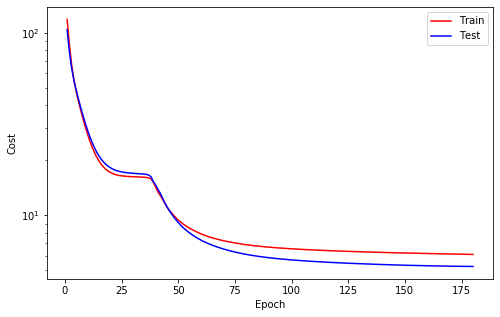



Epoch   181
Train_cost  = 6.0910 | Test_cost  = 5.2351 | 




Epoch   182
Train_cost  = 6.0875 | Test_cost  = 5.2340 | 




Epoch   183
Train_cost  = 6.0840 | Test_cost  = 5.2330 | 




Epoch   184
Train_cost  = 6.0805 | Test_cost  = 5.2321 | 




Epoch   185
Train_cost  = 6.0770 | Test_cost  = 5.2313 | 




Epoch   186
Train_cost  = 6.0734 | Test_cost  = 5.2305 | 




Epoch   187
Train_cost  = 6.0698 | Test_cost  = 5.2299 | 




Epoch   188
Train_cost  = 6.0662 | Test_cost  = 5.2293 | 




Epoch   189
Train_cost  = 6.0626 | Test_cost  = 5.2289 | 




Epoch   190
Train_cost  = 6.0589 | Test_cost  = 5.2285 | 




Epoch   191
Train_cost  = 6.0553 | Test_cost  = 5.2281 | 




Epoch   192
Train_cost  = 6.0516 | Test_cost  = 5.2279 | 




Epoch   193
Train_cost  = 6.0478 | Test_cost  = 5.2277 | 




Epoch   194
Train_cost  = 6.0441 | Test_cost  = 5.2276 | 




Epoch   195
Train_cost  = 6.0403 | Test_cost  = 5.2275 | 




Epoch   196
Train_cost  = 6.0366 | Test_cost  = 5.2275 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2275




Epoch   197
Train_cost  = 6.0328 | Test_cost  = 5.2276 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2275




Epoch   198
Train_cost  = 6.0290 | Test_cost  = 5.2277 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2275




Epoch   199
Train_cost  = 6.0251 | Test_cost  = 5.2279 | 
==> EarlyStop patience =  4 | Best test_cost: 5.2275




Epoch   200
Train_cost  = 6.0213 | Test_cost  = 5.2281 | 


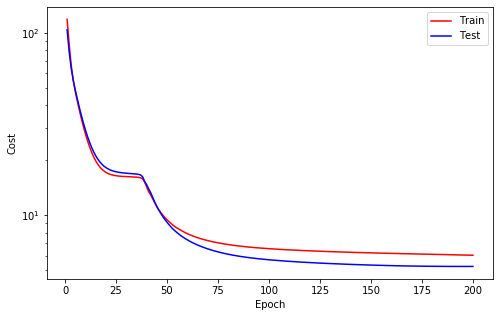

==> EarlyStop patience =  5 | Best test_cost: 5.2275
==> Execute Early Stopping at epoch: 200 | Best test_cost: 5.2275
==> Best model is saved at model/rnn


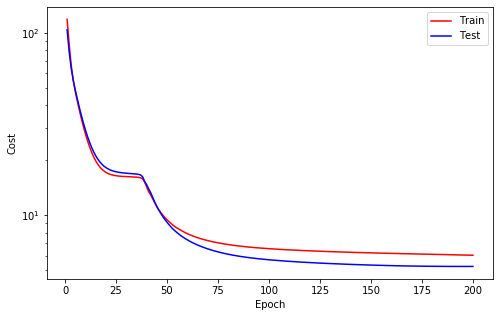

In [30]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [31]:
from luwiji.rnn import illustration

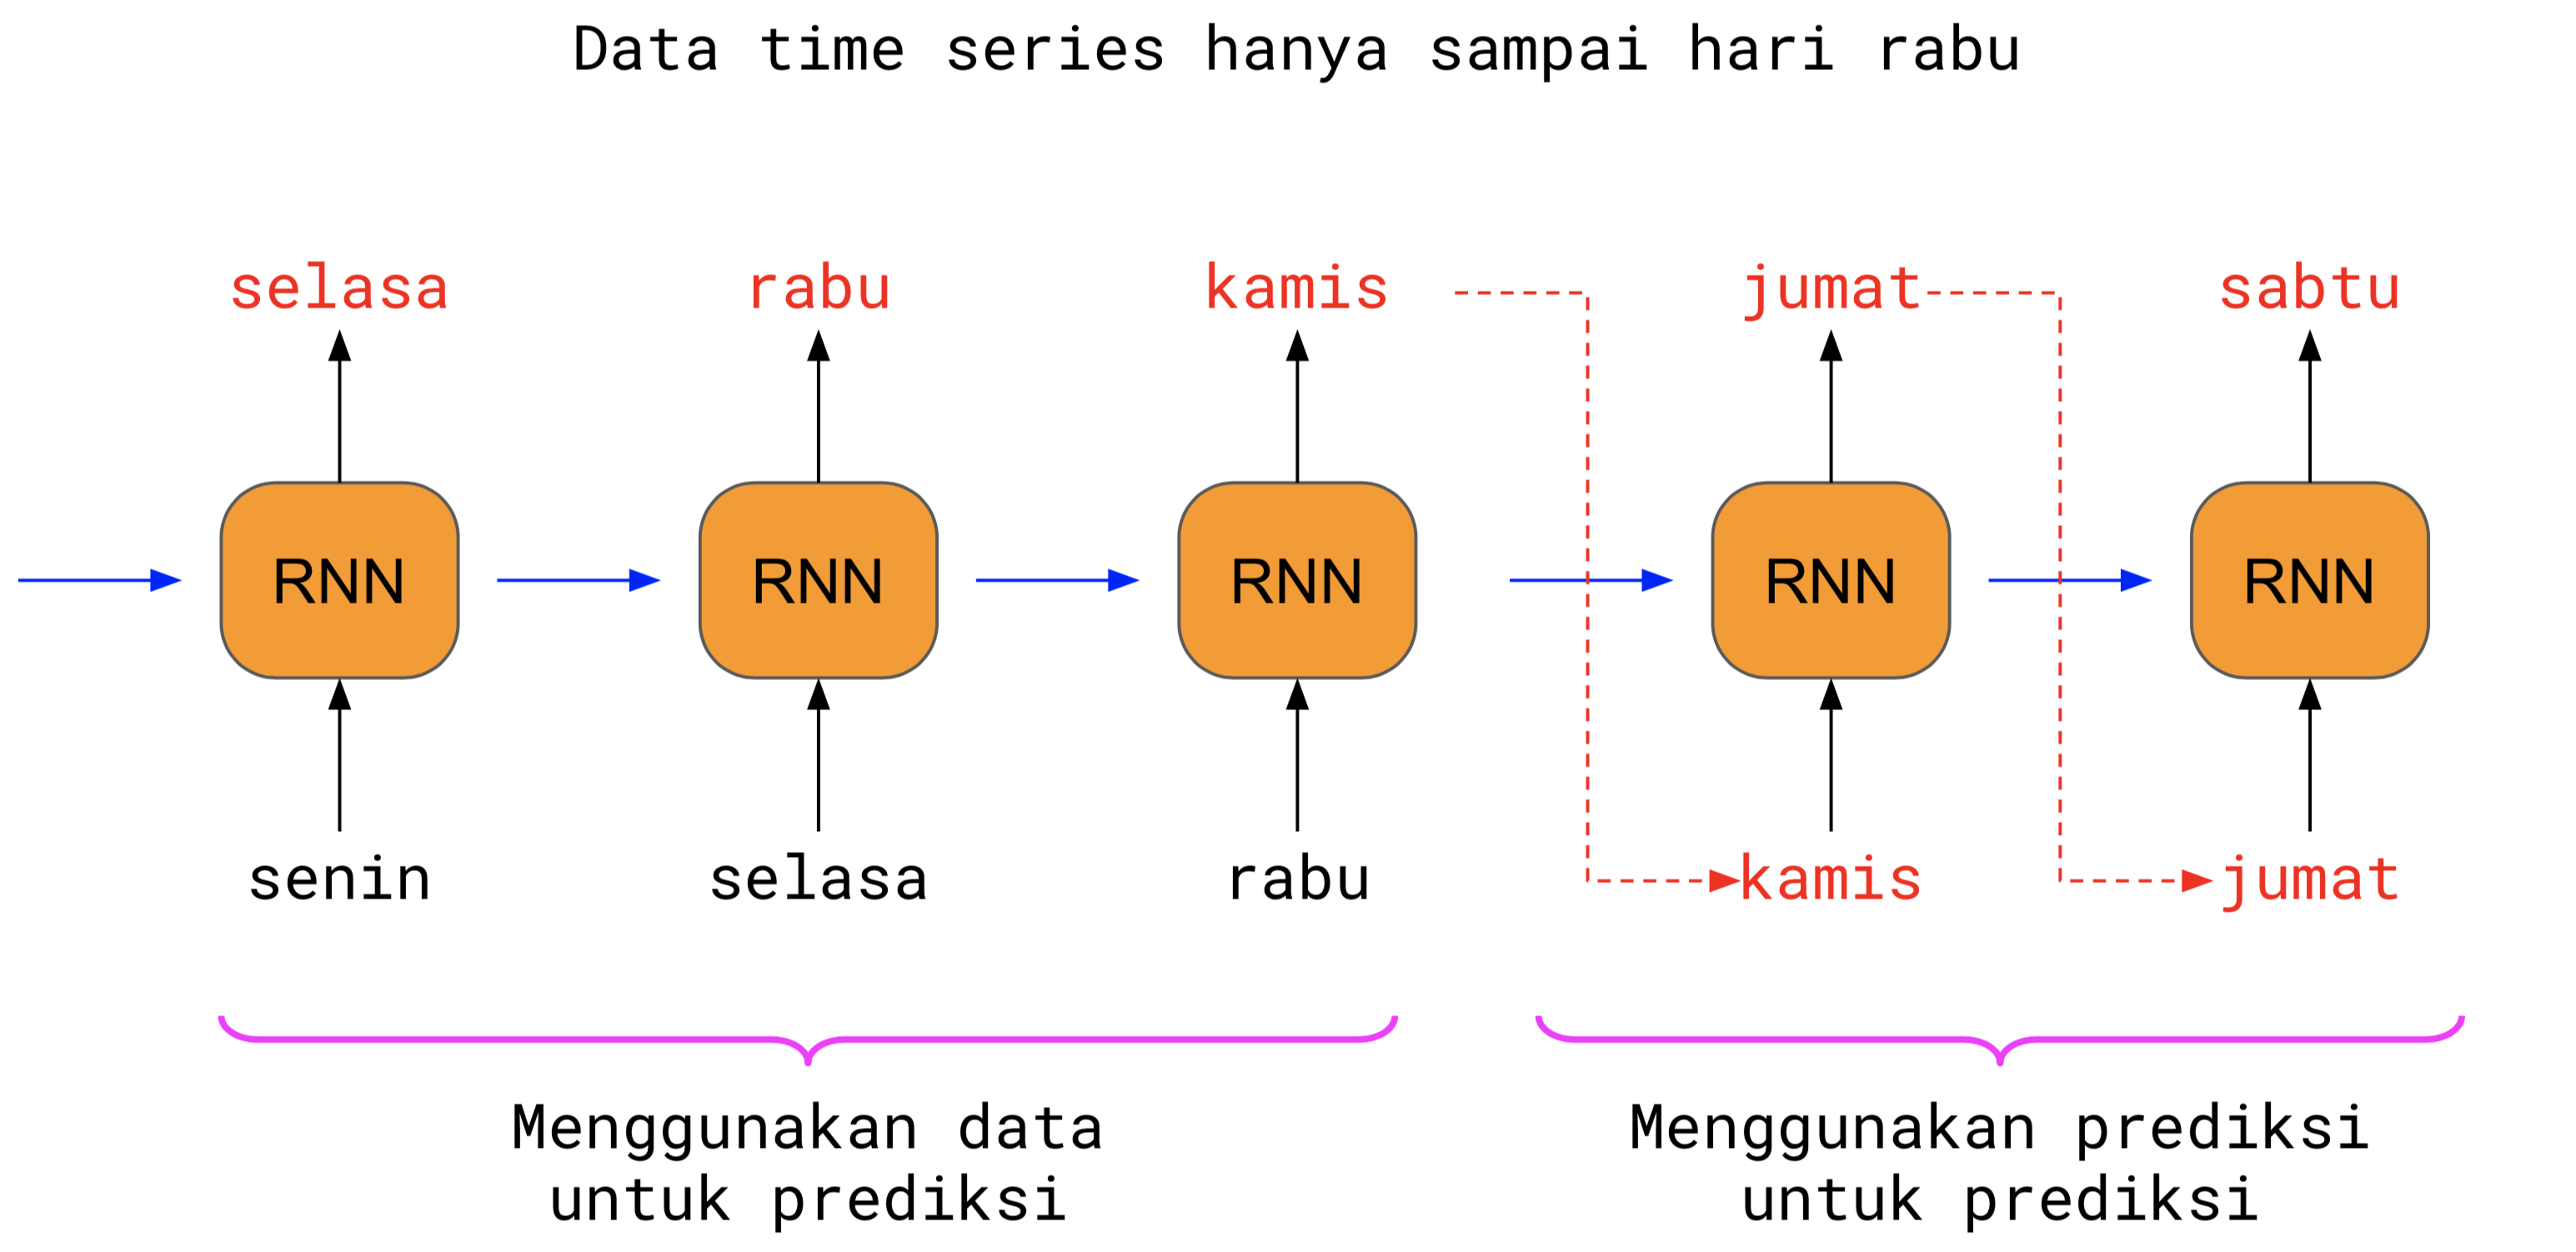

In [32]:
illustration.forecast

In [33]:
from utils import data4pred, pred4pred

In [34]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

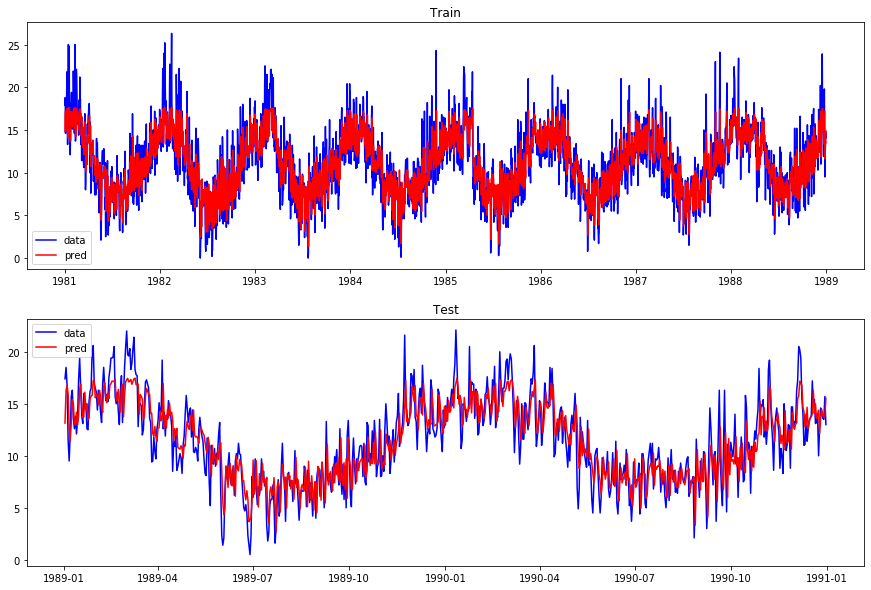

In [35]:
# Data 4 Pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

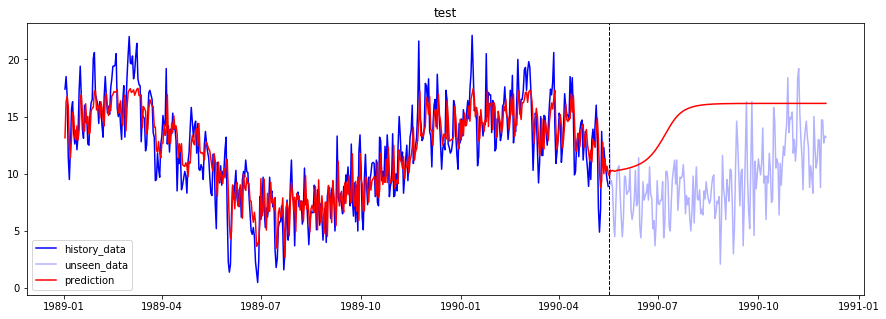

In [36]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")